In [1]:
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
import librosa
import numpy as np
import pandas
import pickle
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import h5py
import math
import random
import re
import csv
from sklearn.manifold import TSNE, MDS

In [3]:
from keras.models import Model, load_model
from keras.layers import Dropout, concatenate, Concatenate, Activation, Input, Dense, Conv2D, GRU, MaxPooling2D, MaxPooling1D, Flatten, Reshape, LeakyReLU, PReLU, BatchNormalization, Bidirectional, TimeDistributed, Lambda, GlobalMaxPool1D, GlobalMaxPool2D, GlobalAveragePooling2D, Multiply, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
import keras.backend as K
from keras import regularizers
from keras.initializers import random_normal, glorot_uniform, glorot_normal
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, Callback, EarlyStopping

In [8]:
path_mel = './melspecs/'
path_files = '../files/'

train_triplet_file = 'train_triplets_50_70_single.pckl'
train_gt_file = 'train_gt_50_70_single.pckl'
train_cons_file = 'train_cons_50_70_single.pckl'
train_trials_file = 'train_trials_50_70_single.pckl'

test_triplet_file = 'test_triplets_50_70_single.pckl'
test_gt_file = 'test_gt_50_70_single.pckl'
test_cons_file = 'test_cons_50_70_single.pckl'
test_trials_file = 'test_trials_50_70_single.pckl'

In [9]:
luscinia_triplets_file = 'luscinia_triplets_filtered.csv'

In [10]:
luscinia_triplets = []
with open(path_files+luscinia_triplets_file, 'r',  newline='') as csvfile:
    csv_r = csv.reader(csvfile, delimiter=',')
    for row in csv_r:
        luscinia_triplets.append(row)

In [11]:
luscinia_triplets = luscinia_triplets[1:]
luscinia_train_len = round(8*len(luscinia_triplets)/10)
luscinia_val_len = len(luscinia_triplets) - luscinia_train_len
print(luscinia_train_len, luscinia_val_len)

83566 20891


In [12]:
f = open(path_files+'mean_std_luscinia_pretraining.pckl', 'rb')
train_dict = pickle.load(f)
M_l = train_dict['mean']
S_l = train_dict['std']
f.close()

In [13]:
f = open(path_files+'training_setup_1_ordered_acc_single_cons_50_70_trials.pckl', 'rb')
train_dict = pickle.load(f)
train_keys = train_dict['train_keys']
training_triplets = train_dict['train_triplets']
val_keys = train_dict['val_keys']
validation_triplets = train_dict['vali_triplets']
test_triplet = train_dict['test_triplets']
test_keys = train_dict['test_keys']
M = train_dict['train_mean']
S = train_dict['train_std']
f.close()

In [25]:
M.shape


(1, 150)

# Network

In [10]:
def convBNpr(a, dilation, num_filters, kernel):
    c1 = Conv2D(filters=num_filters, kernel_size=kernel, strides=(1, 1), dilation_rate=dilation, padding='same', use_bias=False, kernel_initializer=glorot_uniform(seed=123), kernel_regularizer=regularizers.l2(1e-4))(a)
    c1 = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(c1)
    # c1 = Activation('relu')(c1)
    c1 = LeakyReLU(alpha=0.3)(c1)
    return c1
def createModelMatrix(emb_size, input_shape=(170, 150, 1)):
    a = Input(shape=(input_shape)) 
    
    c = convBNpr(a, 1, 12, (3,3))
    c = convBNpr(c, 2, 32, (3,3))
    c = convBNpr(c, 4, 64, (3,3))
    c = convBNpr(c, 8, 128, (3,3))
    # attention with sigmoid
    a1 = Conv2D(filters=128, kernel_size=(1,1), strides=(1, 1), padding='same', activation = 'sigmoid',  use_bias=True, kernel_regularizer=regularizers.l2(1e-4),kernel_initializer=glorot_uniform(seed=123))(c)
    
    # projection with leaky relu 
   # c1 = convBNpr(c, 1, 128, (1,1))
    
    # sum of sum of attention
    s = Lambda(lambda x: K.sum(K.sum(x,axis=1, keepdims=True), axis=2, keepdims=True))(a1)
    s = Lambda(lambda x: K.repeat_elements(x, 170, axis=1))(s)
    s = Lambda(lambda x: K.repeat_elements(x, 150, axis=2))(s)
    
    # probability matrix of attention
    p = Lambda(lambda x: x[0]/x[1])([a1,s])
    
    # inner product of attention and projection matrices
    m = Multiply()([c, p])
    
    # output
    out_sum = Lambda(lambda x: K.sum(K.sum(x, axis=1), axis=1))(m)
    
    # attention side
    #d1 = Dense(emb_size, kernel_initializer=glorot_normal(seed=321), activation='relu')(out_sum)
    #d2 = Dense(emb_size*10, kernel_initializer=glorot_normal(seed=111), activation='relu')(d1)
    d3 = Dense(emb_size*100, kernel_initializer=glorot_normal(seed=222), kernel_regularizer=regularizers.l2(1e-4),activation='relu')(out_sum)
    d3 = Dropout(.2, seed=222)(d3)
    d4 = Dense(emb_size*10, kernel_initializer=glorot_normal(seed=333), kernel_regularizer=regularizers.l2(1e-4),activation='relu')(d3)
    d4 = Dropout(.2, seed=333)(d4)
    d5 = Dense(emb_size, kernel_initializer=glorot_normal(seed=132), kernel_regularizer=regularizers.l2(1e-4))(d4)
    d5 = Dropout(.2, seed = 132)(d5)
    
    # maxpool side
    x = convBNpr(c, 1, 64, (3,3)) 
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = convBNpr(x, 1, 32, (3,3))
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = convBNpr(x, 1, 12, (3,3))

    f = Flatten()(x)
    df1 = Dense(emb_size*100, kernel_initializer=glorot_normal(seed=456), kernel_regularizer=regularizers.l2(1e-4), activation='relu')(f)#
    df1 = Dropout(.2, seed=456)(df1)
    df2 = Dense(emb_size*10, kernel_initializer=glorot_normal(seed=654), kernel_regularizer=regularizers.l2(1e-4), activation='relu')(df1)#
    df2 = Dropout(.2, seed=654)(df2)
    df3 = Dense(emb_size, kernel_initializer=glorot_normal(seed=546), kernel_regularizer=regularizers.l2(1e-4))(df2)#
    df3 = Dropout(.2, seed=546)(df3)

    concat = Concatenate(axis=-1)([d5, df3])
    dd = Dense(emb_size, kernel_initializer=glorot_normal(seed=999), kernel_regularizer=regularizers.l2(1e-4))(concat)

    sph = Lambda(lambda  x: K.l2_normalize(x,axis=1))(dd)
    
    # base model creation
    base_model = Model(a,sph) 
    
    # triplet framework
    input_anchor = Input(shape=(input_shape))
    input_positive = Input(shape=(input_shape))
    input_negative = Input(shape=(input_shape)) 
    
    net_anchor = base_model(input_anchor)
    net_positive = base_model(input_positive)
    net_negative = base_model(input_negative)
    
    base_model.summary()
    
    merged_vector = concatenate([net_anchor, net_positive, net_negative], axis=-1)
    
    model = Model([input_anchor, input_positive, input_negative], outputs=merged_vector)

    return model

# Functions

In [11]:
def masked_weighted_triplet_loss(margin, emb_size, m = 0 , w = 0, lh = 1):
    def lossFunction(y_true,y_pred):
        
        weight = y_true[:, 0] # acc
        cons = y_true[:, 1] # consistency
        trials = y_true[:, 2] # number of trials
        
        #m = K.constant(0.5)
        anchor = y_pred[:, 0:emb_size]
        positive = y_pred[:, emb_size:emb_size*2]
        negative = y_pred[:, emb_size*2:emb_size*3]

        # distance between the anchor and the positive
        pos_dist = K.sqrt(K.sum(K.square(anchor - positive), axis=1)) # l2 distance
        #pos_dist = K.sum(K.abs(anchor-positive), axis=1) # l1 distance

        # distance between the anchor and the negative
        neg_dist = K.sqrt(K.sum(K.square(anchor - negative), axis=1)) # l2 distance
        #neg_dist = K.sum(K.abs(anchor-negative), axis=1) # l1 distance

        loss_h = 0
        loss_l = 0
        
        if lh == 1:
            # DOES NOT WORK WITH MASKED LOSS
            # low-high margin loss
            p_c = K.square(neg_dist) - K.square(pos_dist) - margin  
            p_i = K.square(neg_dist) - K.square(pos_dist)
            
            loss_1 = cons*(1-K.exp(p_c)) + (1-cons)*(1-K.exp(-K.abs(p_i)))
            
            #loss_1 = cons*K.exp(-p_c) + (1-cons)*(1-K.exp(-K.abs(p_c))) # haptic loss
            #loss_1 = K.minimum(trials, K.mean(trials))*loss_1
        if m != 0:
            # masked loss
            basic_loss = pos_dist - neg_dist + margin
            
            threshold = K.max(basic_loss) * m
            mask = 2 + margin - K.maximum(basic_loss, threshold) 

            loss_1 = basic_loss * mask
        
        if w == 1:
            # weighted based on acc
            weighted_loss = weight*loss_1
        else:
            # non-weighted
            weighted_loss = loss_1
            
        loss = K.maximum(weighted_loss, 0.0)

        return loss
    return lossFunction

In [12]:
def discard_some_low(triplet_list, cons, acc):
    low_margin = []
    high_margin = []
    
    for i in range(len(triplet_list)):
        if float(triplet_list[i][-1]) < cons: # low margin
            if float(triplet_list[i][-2]) >= acc: # ACC 
                low_margin.append(triplet_list[i])
        else: # high margin
            high_margin.append(triplet_list[i])
    
    random.seed(123)
    random.shuffle(low_margin)
    random.shuffle(high_margin)
    
    low_margin.extend(high_margin)
        
    return low_margin

In [13]:
def balance_input(triplet_list, cons, hi_balance = 6, lo_balance = 6):
    batchsize = hi_balance + lo_balance
    low_margin = []
    high_margin = []
    
    for i in range(len(triplet_list)):
        if float(triplet_list[i][-1]) < cons: # low margin
            low_margin.append(triplet_list[i])
        else: # high margin
            high_margin.append(triplet_list[i])
    
    random.seed(123)
    random.shuffle(low_margin)
    random.shuffle(high_margin)
    
    new_triplet_list = []
    maxlen = np.maximum(len(low_margin), len(high_margin))
    
    hi_start = 0
    lo_start = 0
    for i in range(0,int(maxlen/hi_balance)*batchsize,batchsize):
        for j in range(hi_start,hi_start+hi_balance,1):
            new_triplet_list.append(high_margin[np.mod(j,len(high_margin))])
        hi_start+=hi_balance
        for j in range(lo_start, lo_start+lo_balance,1):
            new_triplet_list.append(low_margin[np.mod(j,len(low_margin))])
        lo_start+=lo_balance
            
    return low_margin, high_margin, new_triplet_list

# Generators

In [14]:
def train_generator_mixed(triplet_list, M, S, luscinia_triplets, M_l, S_l, batchsize, lo, hi, lu, emb_size, path_mel):
    
    acc_gt = np.zeros((batchsize, emb_size))
   
    random.seed(123)
    #random.shuffle(triplet_list) 
    random.shuffle(luscinia_triplets)
    
    while 1:
    
        anchors_input = np.empty((batchsize, 170, 150, 1))
        positives_input = np.empty((batchsize, 170, 150, 1))
        negatives_input = np.empty((batchsize, 170, 150, 1))
        
        imax = int(len(triplet_list)/(lo+hi))
        
        list_cnt = 0
        luscinia_cnt = 0
        
        for i in range(imax):        
            for j in range(batchsize):
                
                if j < (lo+hi):
                    triplet = triplet_list[list_cnt]
                    list_cnt += 1
                    
                    tr_anc = triplet[3][:-4]+'.pckl'
                    tr_pos = triplet[1][:-4]+'.pckl'
                    tr_neg = triplet[2][:-4]+'.pckl'
                    acc_gt[j][0] = float(triplet[-2]) # acc
                    acc_gt[j][1] = 1 if float(triplet[-1])>=0.7 else 0 # cons
                    acc_gt[j][2] = int(triplet[-3]) # number of trials

                else:
                    triplet = luscinia_triplets[luscinia_cnt]
                    luscinia_cnt += 1
                    
                    tr_anc = triplet[2][:-4]+'.pckl'
                    tr_pos = triplet[0][:-4]+'.pckl'
                    tr_neg = triplet[1][:-4]+'.pckl'
                    acc_gt[j][0] = 1 # acc
                    acc_gt[j][1] = 1  # cons
                    acc_gt[j][2] = 1 # number of trials
                
                f = open(path_mel+tr_anc, 'rb')
                anc = pickle.load(f).T
                f.close()
                anc = (anc - M)/S
                anc = np.expand_dims(anc, axis=-1)
                
                f = open(path_mel+tr_pos, 'rb')
                pos = pickle.load(f).T
                f.close()
                pos = (pos - M)/S
                pos = np.expand_dims(pos, axis=-1)
                
                f = open(path_mel+tr_neg, 'rb')
                neg = pickle.load(f).T
                f.close()
                neg = (neg - M)/S
                neg = np.expand_dims(neg, axis=-1)
                
                anchors_input[j] = anc
                positives_input[j] = pos
                negatives_input[j] = neg
                
            yield [anchors_input, positives_input, negatives_input], acc_gt

In [15]:
def train_generator_luscinia(triplet_list, M, S, batchsize, emb_size, path_mel, ordered = True):
    
    # if ordered == False:
    # triplet list: [[cycle, left, right, anchor, decision], [...], ...]
    # if decision = 0: positive <-- left AND negative <-- right
    # if decision = 1: positive <-- right AND negative <-- left
    
    # if ordered == True:
    #triplet list: [[cycle, positive, negative, anchor, extra_info], [...], ...]
    
    
    #dummy_gt = np.zeros((batchsize, emb_size)) 
    acc_gt = np.zeros((batchsize, emb_size))
    
    #recnames = [f for f in listdir(path_mel) if isfile(join(path, f))]
    
    #anchornames = [recnames[i] for i in anchors]
    #positivenames = [recnames[i] for i in positives]
    #negativenames = [recnames[i] for i in negatives]
    
    random.seed(123)
    random.shuffle(triplet_list) 
    
    while 1:
    
        anchors_input = np.empty((batchsize, 170, 150, 1))
        positives_input = np.empty((batchsize, 170, 150, 1))
        negatives_input = np.empty((batchsize, 170, 150, 1))
        
        imax = int(len(triplet_list)/batchsize)
                
        for i in range(imax):        
            for j in range(batchsize):
                triplet = triplet_list[i*batchsize+j]
                
                tr_anc = triplet[2][:-4]+'.pckl'
                tr_pos = triplet[0][:-4]+'.pckl'
                tr_neg = triplet[1][:-4]+'.pckl'
                acc_gt[j][0] = 1 # acc
                acc_gt[j][1] = 1  # cons
                acc_gt[j][2] = 1 # number of trials
                 
                f = open(path_mel+tr_anc, 'rb')
                anc = pickle.load(f).T
                f.close()
                anc = (anc - M)/S
                anc = np.expand_dims(anc, axis=-1)
                
                f = open(path_mel+tr_pos, 'rb')
                pos = pickle.load(f).T
                f.close()
                pos = (pos - M)/S
                pos = np.expand_dims(pos, axis=-1)
                
                f = open(path_mel+tr_neg, 'rb')
                neg = pickle.load(f).T
                f.close()
                neg = (neg - M)/S
                neg = np.expand_dims(neg, axis=-1)
                
                anchors_input[j] = anc
                positives_input[j] = pos
                negatives_input[j] = neg
                
            yield [anchors_input, positives_input, negatives_input], acc_gt

In [16]:
def train_generator(triplet_list, M, S, batchsize, emb_size, path_mel, ordered = True):
    
    # if ordered == False:
    # triplet list: [[cycle, left, right, anchor, decision], [...], ...]
    # if decision = 0: positive <-- left AND negative <-- right
    # if decision = 1: positive <-- right AND negative <-- left
    
    # if ordered == True:
    #triplet list: [[cycle, positive, negative, anchor, extra_info], [...], ...]
    
    
    #dummy_gt = np.zeros((batchsize, emb_size)) 
    acc_gt = np.zeros((batchsize, emb_size))
    
    #recnames = [f for f in listdir(path_mel) if isfile(join(path, f))]
    
    #anchornames = [recnames[i] for i in anchors]
    #positivenames = [recnames[i] for i in positives]
    #negativenames = [recnames[i] for i in negatives]
    
    random.seed(123)
    random.shuffle(triplet_list) 
    
    while 1:
    
        anchors_input = np.empty((batchsize, 170, 150, 1))
        positives_input = np.empty((batchsize, 170, 150, 1))
        negatives_input = np.empty((batchsize, 170, 150, 1))
        
        imax = int(len(triplet_list)/batchsize)
                
        for i in range(imax):        
            for j in range(batchsize):
                triplet = triplet_list[i*batchsize+j]
                
                tr_anc = triplet[3][:-4]+'.pckl'
                
                if ordered == False:
                    if triplet[-1] == '0':
                        tr_pos = triplet[1][:-4]+'.pckl'
                        tr_neg = triplet[2][:-4]+'.pckl'
                    else:
                        tr_pos = triplet[2][:-4]+'.pckl'
                        tr_neg = triplet[1][:-4]+'.pckl'
                else: # ordered == True
                    tr_pos = triplet[1][:-4]+'.pckl'
                    tr_neg = triplet[2][:-4]+'.pckl'
                    #print(triplet)
                    acc_gt[j][0] = float(triplet[-2]) # acc
                    acc_gt[j][1] = 1 if float(triplet[-1])>=0.7 else 0 # cons
                    acc_gt[j][2] = int(triplet[-3]) # number of trials
                    #print(acc_gt[j])
                    #input()
                f = open(path_mel+tr_anc, 'rb')
                anc = pickle.load(f).T
                f.close()
                anc = (anc - M)/S
                anc = np.expand_dims(anc, axis=-1)
                
                f = open(path_mel+tr_pos, 'rb')
                pos = pickle.load(f).T
                f.close()
                pos = (pos - M)/S
                pos = np.expand_dims(pos, axis=-1)
                
                f = open(path_mel+tr_neg, 'rb')
                neg = pickle.load(f).T
                f.close()
                neg = (neg - M)/S
                neg = np.expand_dims(neg, axis=-1)
                
                anchors_input[j] = anc
                positives_input[j] = pos
                negatives_input[j] = neg
                
            yield [anchors_input, positives_input, negatives_input], acc_gt

# Training

In [45]:
#os.environ["CUDA_VISIBLE_DEVICES"]="2"
emb_size=16
margin = 0.1
m = 0
lr = 1e-8
adam = Adam(lr = lr)

triplet_model = createModelMatrix(emb_size=emb_size, input_shape=(170, 150, 1))
triplet_model.summary()
triplet_model.compile(loss=masked_weighted_triplet_loss(margin=margin, emb_size=emb_size, m=m, w = 0, lh = 1),optimizer=adam) 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 170, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 170, 150, 12) 108         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 170, 150, 12) 48          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 170, 150, 12) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
new_distances = []
acc_cnt = 0
for t_triplet in luscinia_triplets[luscinia_train_len:]:
    #print(t_triplet)
    tr_anc = t_triplet[2][:-4]+'.pckl'
    tr_pos = t_triplet[0][:-4]+'.pckl'
    tr_neg = t_triplet[1][:-4]+'.pckl'
    
    f = open(path_mel+tr_anc, 'rb')
    anc = pickle.load(f).T
    f.close()
    anc = (anc - M)/S
    anc = np.expand_dims(anc, axis=-1)
    anc = np.expand_dims(anc, axis=0)
               
    f = open(path_mel+tr_pos, 'rb')
    pos = pickle.load(f).T
    f.close()
    pos = (pos - M)/S
    pos = np.expand_dims(pos, axis=-1)
    pos = np.expand_dims(pos, axis=0)
                
    f = open(path_mel+tr_neg, 'rb')
    neg = pickle.load(f).T
    f.close()
    neg = (neg - M)/S
    neg = np.expand_dims(neg, axis=-1)
    neg = np.expand_dims(neg, axis=0)
    
    y_pred = triplet_model.predict([anc, pos, neg], batch_size=1, verbose=0)
    
    anchor1 = y_pred[:, 0:emb_size]
    positive1 = y_pred[:, emb_size:emb_size*2]
    negative1 = y_pred[:, emb_size*2:emb_size*3]
    
    #pos_dist = np.sqrt(np.sum(np.square(anchor1 - positive1), axis=1))[0]
    #neg_dist = np.sqrt(np.sum(np.square(anchor1 - negative1), axis=1))[0]

    pos_dist = np.sum(np.abs(anchor1 - positive1), axis=1)[0]
    neg_dist = np.sum(np.abs(anchor1 - negative1), axis=1)[0]

    if pos_dist < neg_dist:
        acc_cnt += 1
    new_distances.append([pos_dist,neg_dist])
    
print('training set accuracy: ',acc_cnt/luscinia_val_len*100, '%') 

# PRE

In [18]:
lo = 6
hi = 8
lu = 10
batchsize = lo+hi+lu #24

cpCallback = ModelCheckpoint('ZF_emb_'+str(emb_size)+'D_LUSCINIA_PRE_margin_loss_backup.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-12)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

#dis_tr_triplets = discard_some_low(training_triplets, 0.7, 0.7)
#dis_val_triplets = discard_some_low(validation_triplets, 0.7, 0.7)

#low_margin, high_margin, bal_training_triplets = balance_input(dis_tr_triplets, 0.7, hi_balance = hi, lo_balance = lo)
#vlow_margin, vhigh_margin, bal_val_triplets = balance_input(dis_val_triplets, 0.7, hi_balance = hi, lo_balance = lo)

history = triplet_model.fit(train_generator_luscinia(luscinia_triplets[:int(luscinia_train_len/10)], M_l, S_l, batchsize, emb_size, path_mel),
                           steps_per_epoch=int(int(luscinia_train_len/10)/batchsize), epochs=1000, verbose=1,
                           validation_data=train_generator_luscinia(luscinia_triplets[luscinia_train_len:luscinia_train_len+200], M_l, S_l, batchsize, emb_size, path_mel),
                           validation_steps=int(200/batchsize), callbacks=[cpCallback, reduce_lr, earlystop])
#history = triplet_model.fit(train_generator_mixed(bal_training_triplets, M, S, luscinia_triplets[:luscinia_train_len],M_l, S_l, batchsize, lo, hi, lu, emb_size, path_mel),
 #                               steps_per_epoch=int(len(bal_training_triplets)/(lo+hi)), epochs=1000, verbose=1,
  #                              validation_data=train_generator_mixed(bal_val_triplets, M, S, luscinia_triplets[luscinia_train_len:],M_l, S_l, batchsize, lo, hi, lu, emb_size, path_mel),
   #                             validation_steps=int(len(bal_val_triplets)/(lo+hi)), callbacks=[cpCallback, reduce_lr, earlystop])

Epoch 1/1000
348/348 [==============================] - 171s 346ms/step - loss: 0.5265 - val_loss: 0.4591
Epoch 2/1000
348/348 [==============================] - 119s 342ms/step - loss: 0.4536 - val_loss: 0.4486
Epoch 3/1000
348/348 [==============================] - 119s 342ms/step - loss: 0.4392 - val_loss: 0.4454
Epoch 4/1000
348/348 [==============================] - 119s 341ms/step - loss: 0.4334 - val_loss: 0.4415
Epoch 5/1000
348/348 [==============================] - 119s 341ms/step - loss: 0.4304 - val_loss: 0.4401
Epoch 6/1000
348/348 [==============================] - 119s 341ms/step - loss: 0.4283 - val_loss: 0.4373
Epoch 7/1000
348/348 [==============================] - 119s 341ms/step - loss: 0.4273 - val_loss: 0.4341
Epoch 8/1000
348/348 [==============================] - 119s 341ms/step - loss: 0.4250 - val_loss: 0.4324
Epoch 9/1000
348/348 [==============================] - 119s 341ms/step - loss: 0.4237 - val_loss: 0.4305
Epoch 10/1000
348/348 [=======================

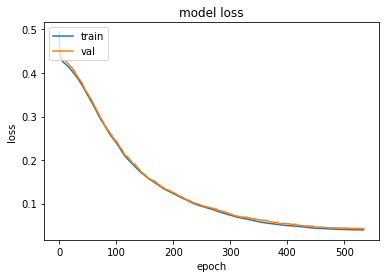

In [20]:
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# PRE trained

In [33]:
triplet_model.load_weights('ZF_emb_'+str(emb_size)+'D_LUSCINIA_PRE_margin_loss_backup.h5')

In [34]:
lo = 6
hi = 8
lu = 10
batchsize = lo+hi+lu #24

cpCallback = ModelCheckpoint('ZF_emb_'+str(emb_size)+'D_LUSCINIA_PRE_margin_loss_trained.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-12)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

dis_tr_triplets = discard_some_low(training_triplets, 0.7, 0.7)
dis_val_triplets = discard_some_low(validation_triplets, 0.7, 0.7)

#low_margin, high_margin, bal_training_triplets = balance_input(dis_tr_triplets, 0.7, hi_balance = hi, lo_balance = lo)
#vlow_margin, vhigh_margin, bal_val_triplets = balance_input(dis_val_triplets, 0.7, hi_balance = hi, lo_balance = lo)

#history = triplet_model.fit(train_generator_luscinia(luscinia_triplets[:int(luscinia_train_len/10)], M_l, S_l, batchsize, emb_size, path_mel),
 #                          steps_per_epoch=int(int(luscinia_train_len/10)/batchsize), epochs=1000, verbose=1,
  #                         validation_data=train_generator_luscinia(luscinia_triplets[luscinia_train_len:luscinia_train_len+200], M_l, S_l, batchsize, emb_size, path_mel),
   #                        validation_steps=int(200/batchsize), callbacks=[cpCallback, reduce_lr, earlystop])
#history = triplet_model.fit(train_generator_mixed(bal_training_triplets, M, S, luscinia_triplets[:luscinia_train_len],M_l, S_l, batchsize, lo, hi, lu, emb_size, path_mel),
 #                               steps_per_epoch=int(len(bal_training_triplets)/(lo+hi)), epochs=1000, verbose=1,
  #                              validation_data=train_generator_mixed(bal_val_triplets, M, S, luscinia_triplets[luscinia_train_len:],M_l, S_l, batchsize, lo, hi, lu, emb_size, path_mel),
   #                             validation_steps=int(len(bal_val_triplets)/(lo+hi)), callbacks=[cpCallback, reduce_lr, earlystop])
history = triplet_model.fit(train_generator(dis_tr_triplets, M, S, batchsize, emb_size, path_mel),
                           steps_per_epoch=int(len(dis_tr_triplets)/batchsize), epochs=1000, verbose=1,
                           validation_data=train_generator(dis_val_triplets, M,S, batchsize, emb_size, path_mel),
                           validation_steps=int(len(dis_val_triplets)/batchsize), callbacks=[cpCallback, reduce_lr,earlystop])

Epoch 1/1000
58/58 [==============================] - 28s 394ms/step - loss: 0.1178 - val_loss: 0.1106
Epoch 2/1000
58/58 [==============================] - 22s 377ms/step - loss: 0.1201 - val_loss: 0.1079
Epoch 3/1000
58/58 [==============================] - 22s 377ms/step - loss: 0.1196 - val_loss: 0.1073
Epoch 4/1000
58/58 [==============================] - 22s 377ms/step - loss: 0.1166 - val_loss: 0.1070
Epoch 5/1000
58/58 [==============================] - 22s 377ms/step - loss: 0.1183 - val_loss: 0.1068
Epoch 6/1000
58/58 [==============================] - 22s 377ms/step - loss: 0.1158 - val_loss: 0.1066
Epoch 7/1000
58/58 [==============================] - 22s 377ms/step - loss: 0.1166 - val_loss: 0.1064
Epoch 8/1000
58/58 [==============================] - 22s 377ms/step - loss: 0.1157 - val_loss: 0.1062
Epoch 9/1000
58/58 [==============================] - 22s 377ms/step - loss: 0.1146 - val_loss: 0.1060
Epoch 10/1000
58/58 [==============================] - 22s 377ms/step - l

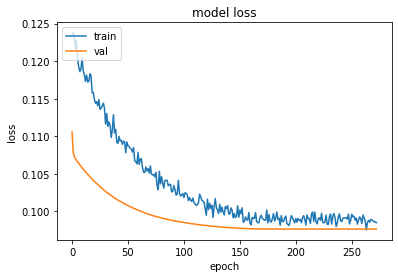

In [35]:
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# MIXED

In [37]:
lo = 6
hi = 8
lu = 10
batchsize = lo+hi+lu #26

cpCallback = ModelCheckpoint('ZF_emb_'+str(emb_size)+'D_LUSCINIA_MIXED_margin_loss.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-12)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

dis_tr_triplets = discard_some_low(training_triplets, 0.7, 0.7)
dis_val_triplets = discard_some_low(validation_triplets, 0.7, 0.7)

low_margin, high_margin, bal_training_triplets = balance_input(dis_tr_triplets, 0.7, hi_balance = hi, lo_balance = lo)
vlow_margin, vhigh_margin, bal_val_triplets = balance_input(dis_val_triplets, 0.7, hi_balance = hi, lo_balance = lo)

#history = triplet_model.fit(train_generator_luscinia(luscinia_triplets[:int(luscinia_train_len/10)], M_l, S_l, batchsize, emb_size, path_mel),
 #                          steps_per_epoch=int(int(luscinia_train_len/10)/batchsize), epochs=1000, verbose=1,
  #                         validation_data=train_generator_luscinia(luscinia_triplets[luscinia_train_len:luscinia_train_len+200], M_l, S_l, batchsize, emb_size, path_mel),
   #                        validation_steps=int(200/batchsize), callbacks=[cpCallback, reduce_lr, earlystop])
history = triplet_model.fit(train_generator_mixed(bal_training_triplets, M, S, luscinia_triplets[:luscinia_train_len],M_l, S_l, batchsize, lo, hi, lu, emb_size, path_mel),
                                steps_per_epoch=int(len(bal_training_triplets)/(lo+hi)), epochs=1000, verbose=1,
                                validation_data=train_generator_mixed(bal_val_triplets, M, S, luscinia_triplets[luscinia_train_len:],M_l, S_l, batchsize, lo, hi, lu, emb_size, path_mel),
                                validation_steps=int(len(bal_val_triplets)/(lo+hi)), callbacks=[cpCallback, reduce_lr, earlystop])
#history = triplet_model.fit(train_generator(dis_tr_triplets, M, S, batchsize, emb_size, path_mel),
 #                          steps_per_epoch=int(len(dis_tr_triplets)/batchsize), epochs=1000, verbose=1,
  #                         validation_data=train_generator(dis_val_triplets, M,S, batchsize, emb_size, path_mel),
   #                        validation_steps=int(len(dis_val_triplets)/batchsize), callbacks=[cpCallback, reduce_lr,earlystop])

Epoch 1/1000
117/117 [==============================] - 50s 380ms/step - loss: 0.6301 - val_loss: 0.5736
Epoch 2/1000
117/117 [==============================] - 43s 372ms/step - loss: 0.6108 - val_loss: 0.5940
Epoch 3/1000
117/117 [==============================] - 43s 372ms/step - loss: 0.6125 - val_loss: 0.5691
Epoch 4/1000
117/117 [==============================] - 43s 372ms/step - loss: 0.5836 - val_loss: 0.5496
Epoch 5/1000
117/117 [==============================] - 43s 372ms/step - loss: 0.5807 - val_loss: 0.5335
Epoch 6/1000
117/117 [==============================] - 43s 372ms/step - loss: 0.5562 - val_loss: 0.5218
Epoch 7/1000
117/117 [==============================] - 43s 372ms/step - loss: 0.5476 - val_loss: 0.5129
Epoch 8/1000
117/117 [==============================] - 43s 372ms/step - loss: 0.5425 - val_loss: 0.5063
Epoch 9/1000
117/117 [==============================] - 44s 372ms/step - loss: 0.5374 - val_loss: 0.5008
Epoch 10/1000
117/117 [==============================] 

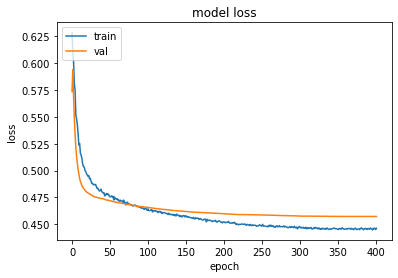

In [39]:
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
K.clear_session()

# PRE + MIXED

In [ ]:
triplet_model.load_weights('ZF_emb_'+str(emb_size)+'D_LUSCINIA_PRE_margin_loss_backup.h5')
lo = 6
hi = 8
lu = 10
batchsize = lo+hi+lu #26

cpCallback = ModelCheckpoint('ZF_emb_'+str(emb_size)+'D_LUSCINIA_PRE_MIXED_margin_loss.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-12)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

dis_tr_triplets = discard_some_low(training_triplets, 0.7, 0.7)
dis_val_triplets = discard_some_low(validation_triplets, 0.7, 0.7)

low_margin, high_margin, bal_training_triplets = balance_input(dis_tr_triplets, 0.7, hi_balance = hi, lo_balance = lo)
vlow_margin, vhigh_margin, bal_val_triplets = balance_input(dis_val_triplets, 0.7, hi_balance = hi, lo_balance = lo)

#history = triplet_model.fit(train_generator_luscinia(luscinia_triplets[:int(luscinia_train_len/10)], M_l, S_l, batchsize, emb_size, path_mel),
 #                          steps_per_epoch=int(int(luscinia_train_len/10)/batchsize), epochs=1000, verbose=1,
  #                         validation_data=train_generator_luscinia(luscinia_triplets[luscinia_train_len:luscinia_train_len+200], M_l, S_l, batchsize, emb_size, path_mel),
   #                        validation_steps=int(200/batchsize), callbacks=[cpCallback, reduce_lr, earlystop])
history = triplet_model.fit(train_generator_mixed(bal_training_triplets, M, S, luscinia_triplets[:luscinia_train_len],M_l, S_l, batchsize, lo, hi, lu, emb_size, path_mel),
                                steps_per_epoch=int(len(bal_training_triplets)/(lo+hi)), epochs=1000, verbose=1,
                                validation_data=train_generator_mixed(bal_val_triplets, M, S, luscinia_triplets[luscinia_train_len:],M_l, S_l, batchsize, lo, hi, lu, emb_size, path_mel),
                                validation_steps=int(len(bal_val_triplets)/(lo+hi)), callbacks=[cpCallback, reduce_lr, earlystop])
#history = triplet_model.fit(train_generator(dis_tr_triplets, M, S, batchsize, emb_size, path_mel),
 #                          steps_per_epoch=int(len(dis_tr_triplets)/batchsize), epochs=1000, verbose=1,
  #                         validation_data=train_generator(dis_val_triplets, M,S, batchsize, emb_size, path_mel),
   #                        validation_steps=int(len(dis_val_triplets)/batchsize), callbacks=[cpCallback, reduce_lr,earlystop])

Epoch 1/1000
117/117 [==============================] - 50s 380ms/step - loss: 0.0973 - val_loss: 0.0863
Epoch 2/1000
117/117 [==============================] - 43s 372ms/step - loss: 0.0958 - val_loss: 0.0856
Epoch 3/1000
117/117 [==============================] - 43s 372ms/step - loss: 0.0949 - val_loss: 0.0852
Epoch 4/1000
117/117 [==============================] - 43s 372ms/step - loss: 0.0937 - val_loss: 0.0849
Epoch 5/1000
117/117 [==============================] - 43s 372ms/step - loss: 0.0921 - val_loss: 0.0845
Epoch 6/1000
117/117 [==============================] - 44s 375ms/step - loss: 0.0927 - val_loss: 0.0842
Epoch 7/1000
117/117 [==============================] - 43s 372ms/step - loss: 0.0911 - val_loss: 0.0839
Epoch 8/1000
117/117 [==============================] - 43s 372ms/step - loss: 0.0919 - val_loss: 0.0836
Epoch 9/1000
117/117 [==============================] - 43s 372ms/step - loss: 0.0894 - val_loss: 0.0834
Epoch 10/1000
117/117 [==============================] 

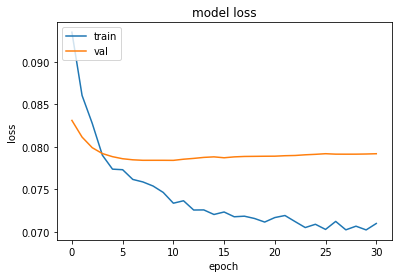

In [43]:
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluation

In [ ]:
def low_high_evaluation(path_mel, vhigh_margin, vlow_margin, triplet_model, margin = 0.00000001, max_margin = 0.0000001, step = 0.00000001):
    # pos, neg, anc
    while margin < max_margin:
        acc_cnt = 0
        high_cnt = 0
        low_cnt = 0
        for triplet in vhigh_margin:
            tr_pos = triplet[1][:-4]+'.pckl'
            tr_neg = triplet[2][:-4]+'.pckl'
            tr_anc = triplet[3][:-4]+'.pckl'

            f = open(path_mel+tr_anc, 'rb')
            anc = pickle.load(f).T
            f.close()
            anc = (anc - M)/S
            anc = np.expand_dims(anc, axis=0)
            anc = np.expand_dims(anc, axis=-1)

            f = open(path_mel+tr_pos, 'rb')
            pos = pickle.load(f).T
            f.close()
            pos = (pos - M)/S
            pos = np.expand_dims(pos, axis=0)
            pos = np.expand_dims(pos, axis=-1)

            f = open(path_mel+tr_neg, 'rb')
            neg = pickle.load(f).T
            f.close()
            neg = (neg - M)/S
            neg = np.expand_dims(neg, axis=0)
            neg = np.expand_dims(neg, axis=-1)

            y_pred = triplet_model.predict([anc, pos, neg])

            anchor1 = y_pred[:, 0:emb_size]
            positive1 = y_pred[:, emb_size:emb_size*2]
            negative1 = y_pred[:, emb_size*2:emb_size*3]

            pos_dist = np.sqrt(np.sum(np.square(anchor1 - positive1), axis=1))[0]
            neg_dist = np.sqrt(np.sum(np.square(anchor1 - negative1), axis=1))[0]

            if np.square(neg_dist) > np.square(pos_dist) + margin:
                acc_cnt += 1
                high_cnt += 1
        for triplet in vlow_margin:
            tr_pos = triplet[1][:-4]+'.pckl'
            tr_neg = triplet[2][:-4]+'.pckl'
            tr_anc = triplet[3][:-4]+'.pckl'

            f = open(path_mel+tr_anc, 'rb')
            anc = pickle.load(f).T
            f.close()
            anc = (anc - M)/S
            anc = np.expand_dims(anc, axis=0)
            anc = np.expand_dims(anc, axis=-1)

            f = open(path_mel+tr_pos, 'rb')
            pos = pickle.load(f).T
            f.close()
            pos = (pos - M)/S
            pos = np.expand_dims(pos, axis=0)
            pos = np.expand_dims(pos, axis=-1)

            f = open(path_mel+tr_neg, 'rb')
            neg = pickle.load(f).T
            f.close()
            neg = (neg - M)/S
            neg = np.expand_dims(neg, axis=0)
            neg = np.expand_dims(neg, axis=-1)

            y_pred = triplet_model.predict([anc, pos, neg])

            anchor1 = y_pred[:, 0:emb_size]
            positive1 = y_pred[:, emb_size:emb_size*2]
            negative1 = y_pred[:, emb_size*2:emb_size*3]

            pos_dist = np.sqrt(np.sum(np.square(anchor1 - positive1), axis=1))[0]
            neg_dist = np.sqrt(np.sum(np.square(anchor1 - negative1), axis=1))[0]

            if np.abs(np.square(pos_dist) - np.square(neg_dist)) <= margin:
                acc_cnt+=1
                low_cnt+=1
        print('MARGIN = ', margin)
        print('Macro-average Low-High margin accuracy: ',0.5*(high_cnt/(len(vhigh_margin)) + low_cnt/(len(vlow_margin)))*100, '%')
        print('Micro-average Low-High margin accuracy: ',(acc_cnt/(len(vhigh_margin)+len(vlow_margin)))*100, '%') 
        print('High margin accuracy: ',(high_cnt/(len(vhigh_margin)))*100, '%')  
        print('Low margin accuracy: ',(low_cnt/(len(vlow_margin)))*100, '%')  
        margin += step
        
    return 

In [ ]:
low_margin = pickle.load( open(path_files+'train_triplets_low_50_70_ACC70.pckl', 'rb'))
vlow_margin = pickle.load(open(path_files+'val_triplets_low_50_70_ACC70.pckl', 'rb'))
high_margin = pickle.load(open(path_files+'train_triplets_high_50_70_ACC70.pckl', 'rb'))
vhigh_margin =pickle.load(open(path_files+'val_triplets_high_50_70_ACC70.pckl', 'rb'))
tlow_margin =pickle.load(open(path_files+'test_triplets_low_50_70_ACC70.pckl', 'rb'))
thigh_margin = pickle.load(open(path_files+'test_triplets_high_50_70_ACC70.pckl', 'rb'))

In [ ]:
low_high_evauation(path_mel, high_margin, low_margin, triplet_model, margin = 0.0, max_margin = 0.01, step = 0.005)

# Agreement

In [ ]:
file = path_files+'TunedLusciniaV1e.csv'
comp = []
header = 1
with open(file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        if header == 1:
            header = 0
            print(row)
            continue
        if row:
            if len(row[-1].split(' '))>0:
                row[-1] = row[-1].replace(' ', '_')
            if len(row[-2].split(' '))>0:
                row[-2] = row[-2].replace(' ', '_')
            comp.append([row[-3], row[-2], row[-1]])
luscinia_tuned = np.asarray(comp)

In [ ]:
def luscinia_comparison(path_mel, vhigh_margin, triplet_model, luscinia_tuned):
    acc = 0
    agree = []
    for triplet in vhigh_margin:
        tr_pos = triplet[1][:-4]+'.pckl'
        tr_neg = triplet[2][:-4]+'.pckl'
        tr_anc = triplet[3][:-4]+'.pckl'

        f = open(path_mel+tr_anc, 'rb')
        anc = pickle.load(f).T
        f.close()
        anc = (anc - M)/S
        anc = np.expand_dims(anc, axis=0)
        anc = np.expand_dims(anc, axis=-1)

        f = open(path_mel+tr_pos, 'rb')
        pos = pickle.load(f).T
        f.close()
        pos = (pos - M)/S
        pos = np.expand_dims(pos, axis=0)
        pos = np.expand_dims(pos, axis=-1)

        f = open(path_mel+tr_neg, 'rb')
        neg = pickle.load(f).T
        f.close()
        neg = (neg - M)/S
        neg = np.expand_dims(neg, axis=0)
        neg = np.expand_dims(neg, axis=-1)

        y_pred = triplet_model.predict([anc, pos, neg])

        anchor1 = y_pred[:, 0:emb_size]
        positive1 = y_pred[:, emb_size:emb_size*2]
        negative1 = y_pred[:, emb_size*2:emb_size*3]

        pos_dist = np.sum(np.abs(anchor1 - positive1), axis=1)[0]
        neg_dist = np.sum(np.abs(anchor1 - negative1), axis=1)[0]

        if np.square(neg_dist) > np.square(pos_dist):
            dnn = 1
        else:
            dnn = 0
        
        pos = triplet[1]
        neg = triplet[2]
        anc = triplet[3]
            
        pos_i_1 = np.squeeze(np.argwhere(luscinia_tuned[:,-1]==pos), axis=1)
        neg_i_1 = np.squeeze(np.argwhere(luscinia_tuned[:,-1]==neg), axis=1)
        pos_i_2 = np.squeeze(np.argwhere(luscinia_tuned[:,-2]==pos), axis=1)
        neg_i_2 = np.squeeze(np.argwhere(luscinia_tuned[:,-2]==neg), axis=1)
            
        anc_i_1 = np.squeeze(np.argwhere(luscinia_tuned[:,-1] == anc), axis=1)
        anc_i_2 = np.squeeze(np.argwhere(luscinia_tuned[:,-2] == anc), axis=1)

        if len(np.intersect1d(pos_i_1, anc_i_2, assume_unique=True))>0:
            row_p = np.intersect1d(pos_i_1, anc_i_2, assume_unique=True)[0]
        elif len(np.intersect1d(pos_i_2, anc_i_1, assume_unique=True))>0:
            row_p = np.intersect1d(pos_i_2, anc_i_1, assume_unique=True)[0]
        else:
            print('ERROR')
                
        if len(np.intersect1d(neg_i_1, anc_i_2, assume_unique=True))>0:
            row_n = np.intersect1d(neg_i_1, anc_i_2, assume_unique=True)[0]
        elif len(np.intersect1d(neg_i_2, anc_i_1, assume_unique=True))>0:
            row_n = np.intersect1d(neg_i_2, anc_i_1, assume_unique=True)[0]
        else:
            print('ERROR')
           

        acc_p = 1 - float(luscinia_tuned[row_p,-3])
        acc_n = 1- float(luscinia_tuned[row_n,-3])

        if np.square(float(acc_p)) > np.square(float(acc_n)):  # sim_p > sim_n + margin
            lusc = 1
        else:
            lusc = 0
        
        if dnn == lusc:
            acc += 1
        agree.append([dnn,lusc])
    print('total agreement ', acc, ' out of ', len(vhigh_margin))
    print('agreement(%): ', acc/len(vhigh_margin)*100)
    return agree

In [ ]:
triplet_model.load_weights('ZF_emb_'+str(emb_size)+'D_LUSCINIA_PRE_MIXED_margin_loss.h5')
margin = luscinia_comparison(path_mel, thigh_margin, triplet_model, luscinia_tuned)